In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, LSTM, GRU, Dense, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Add, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import tensorflow as tf

# --- Load all sensor data and stack into 3D array (samples, timesteps, features) ---

def load_sensor_data(base_path, sensor_name):
    # sensor_name e.g. 'body_acc_x_train.txt'
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_train.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_train.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_train.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_train.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_train.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_train.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_train.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_train.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_train.txt')

# Stack all 9 axes into (samples, timesteps, features=9)
# Each input file shape: (7352, 128) -- 7352 samples, 128 time steps each
X = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z
], axis=2)  # shape: (7352, 128, 9)

print("X shape:", X.shape)

# Load labels
y = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt", delim_whitespace=True, header=None).values.flatten()

# --- Standardize data per feature (flatten first) ---
nsamples, ntimesteps, nfeatures = X.shape
X_reshaped = X.reshape(-1, nfeatures)  # shape (7352*128, 9)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

X_scaled = X_scaled.reshape(nsamples, ntimesteps, nfeatures)

# Encode labels to 0-based integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Labels:", np.unique(y_encoded))




C:\Users\MSI\AppData\Local\Temp\ipykernel_4920\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_4920\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_4920\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_4920\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and

X shape: (7352, 128, 9)


C:\Users\MSI\AppData\Local\Temp\ipykernel_4920\669504868.py:45: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt", delim_whitespace=True, header=None).values.flatten()


Labels: [0 1 2 3 4 5]


In [3]:
def build_cnn_lstm_gru_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    conv1 = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    x = Add()([x, conv1])
    x = Dropout(0.2)(x)

    x = LSTM(64, return_sequences=True)(x)
    x = GRU(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [5]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 217ms/step - accuracy: 0.6535 - loss: 2.3269 - val_accuracy: 0.8919 - val_loss: 1.0657 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 293ms/step - accuracy: 0.9282 - loss: 0.8374 - val_accuracy: 0.9449 - val_loss: 0.5570 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 339ms/step - accuracy: 0.9390 - loss: 0.4829 - val_accuracy: 0.9483 - val_loss: 0.3675 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.9440 - loss: 0.3566 - val_accuracy: 0.9388 - val_loss: 0.3582 - learning_rate: 0.0010
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 275ms/step - accuracy: 0.9376 - loss: 0.3251 - val_accuracy: 0.9545 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.9362 - loss: 0.2726 - val_accuracy: 0.9572 - val_loss: 0.2358 - learning_rate: 0.0010
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.9433 - loss: 0.

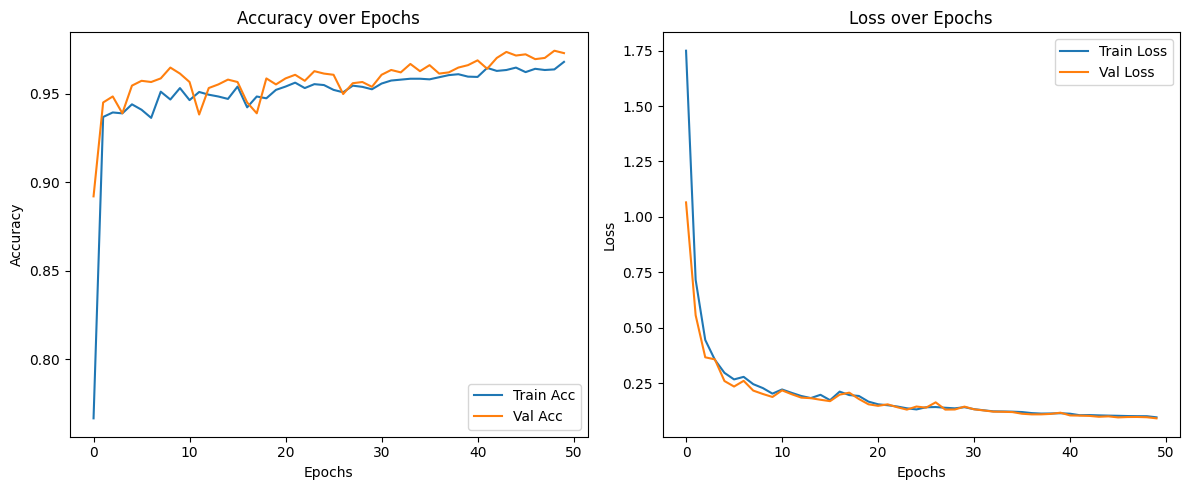

In [6]:
model = build_cnn_lstm_gru_model(input_shape=(ntimesteps, nfeatures), num_classes=len(np.unique(y_encoded)))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:\n")
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_.astype(str)))

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)




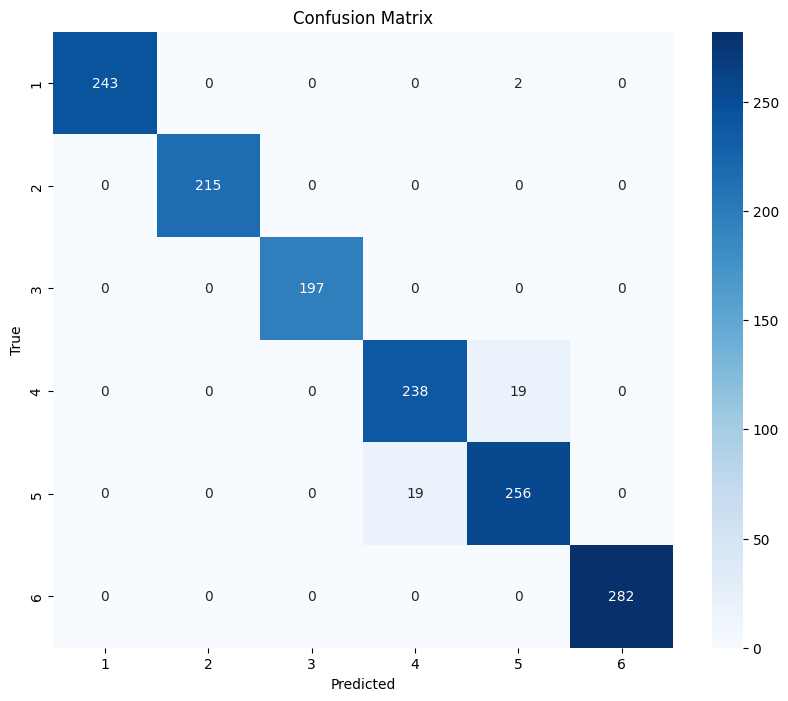

In [7]:
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 64)   │      2,944 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 64)   │     20,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 64)   │          0 │ dropout[0][0],    │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 64)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128, 64)   │     33,024 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     24,960 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │        774 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 272,724 (1.04 MB)

 Trainable params: 90,822 (354.77 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 181,646 (709.56 KB)

In [9]:
model.save(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\CNN_LSTM_GRU.h5")

C:\Users\MSI\AppData\Local\Temp\ipykernel_4920\42607500.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_4920\42607500.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_4920\42607500.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_4920\42607500.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and wil

X_test shape: (2947, 128, 9)
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Accuracy: 0.9239904988123515

Classification Report:

              precision    recall  f1-score   support

           1       1.00      0.94      0.97       496
           2       0.99      0.96      0.98       471
           3       0.90      1.00      0.95       420
           4       0.79      0.87      0.83       491
           5       0.89      0.79      0.83       532
           6       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.93      0.92      2947
weighted avg       0.93      0.92      0.92      2947



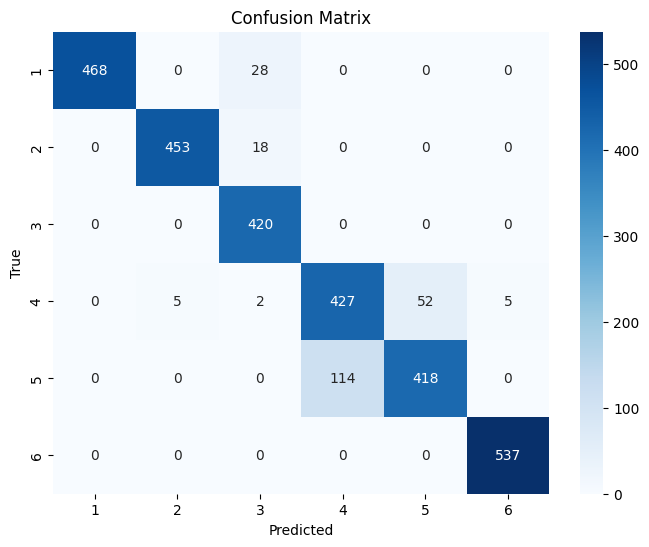

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load test sensor signal data from UCI HAR Dataset ---
def load_sensor_data(base_path, sensor_name):
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

# Use the TEST path, not TRAIN
base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_test.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_test.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_test.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_test.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_test.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_test.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_test.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_test.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_test.txt')

# Stack all 9 axes into shape: (samples, timesteps, features=9)
X_test = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z
], axis=2)

print("X_test shape:", X_test.shape)  # should be (2947, 128, 9)

# --- Load test labels ---
y_test = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\y_test.txt", delim_whitespace=True, header=None).values.flatten()

# --- Standardize data ---
nsamples, ntimesteps, nfeatures = X_test.shape
X_test_reshaped = X_test.reshape(-1, nfeatures)  # shape: (2947*128, 9)

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_reshaped)

X_test_scaled = X_test_scaled.reshape(nsamples, ntimesteps, nfeatures)

# --- Label encode y_test ---
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# --- Load your trained model ---
model = load_model(r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\CNN_LSTM_GRU.h5')

# --- Predict ---
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- Evaluate ---
# === Evaluate ===
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_classes))
print("\nClassification Report:\n")
# Convert class labels to string if they are integers
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test_encoded, y_pred_classes, target_names=target_names))

# --- Confusion matrix ---
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
